<a href="https://colab.research.google.com/github/JavisBizzareAdventure/Opt3FinalProject/blob/main/ThisProyectoFinalOpt3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 28 12:02:32 2021

@author: Javier Zamora
"""

'\nCreated on Fri May 28 12:02:32 2021\n\n@author: Javier Zamora\n'

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pneumonia Filters

In this proyect we were tasked to classify between normal, bacterian and viral patients of pneumonia for the dataset "Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification", found over at https://data.mendeley.com/datasets/rscbjbr9sj/2 , with a CNN. Objective is to get over 92% accuracy, showing confusion matrix and F1 scores to demonstrate it's working properly.

I'm using only the train folder from this dataset to train my CNN, as uploading all the dataset to Drive is time expensive, I'm using colab to make this project hence the Drive upload. Also I divided "PNEUMONIA" folder as it had bacterian and viral infections, this to give them different classes.

## Pre-processing

We called the Directories to wich the dataset was saved, we print an image of each set to make sure we are usig the correct direcotry.

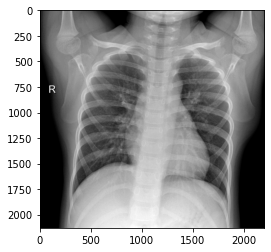

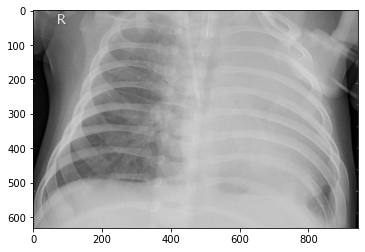

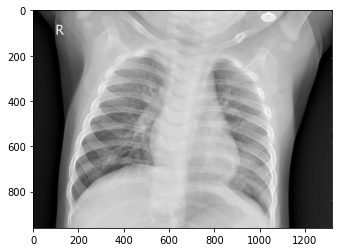

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas
import cv2

DATADIR = "/content/drive/My Drive/Colab Notebooks/train"
CATEGORIES = ["NORMAL","BACTERIA","VIRUS"]

path = os.path.join(DATADIR, CATEGORIES[0]) # path to a normal pneumonia patient
for img in os.listdir(path):
    img_array_N = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array_N, cmap="gray")
    plt.show()
    break
path = os.path.join(DATADIR, CATEGORIES[1]) # path to a bacterian pneumonia patient
for img in os.listdir(path):
    img_array_B = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array_B, cmap="gray")
    plt.show()
    break
path = os.path.join(DATADIR, CATEGORIES[2]) # path to a virial pneumonia patient
for img in os.listdir(path):
    img_array_V = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array_V, cmap="gray")
    plt.show()
    break

We tried some new sizes for the images to see how far can we take the compression without loosing important image details and also to normalize each photo.

Text(0.5, 1.0, 'Virus')

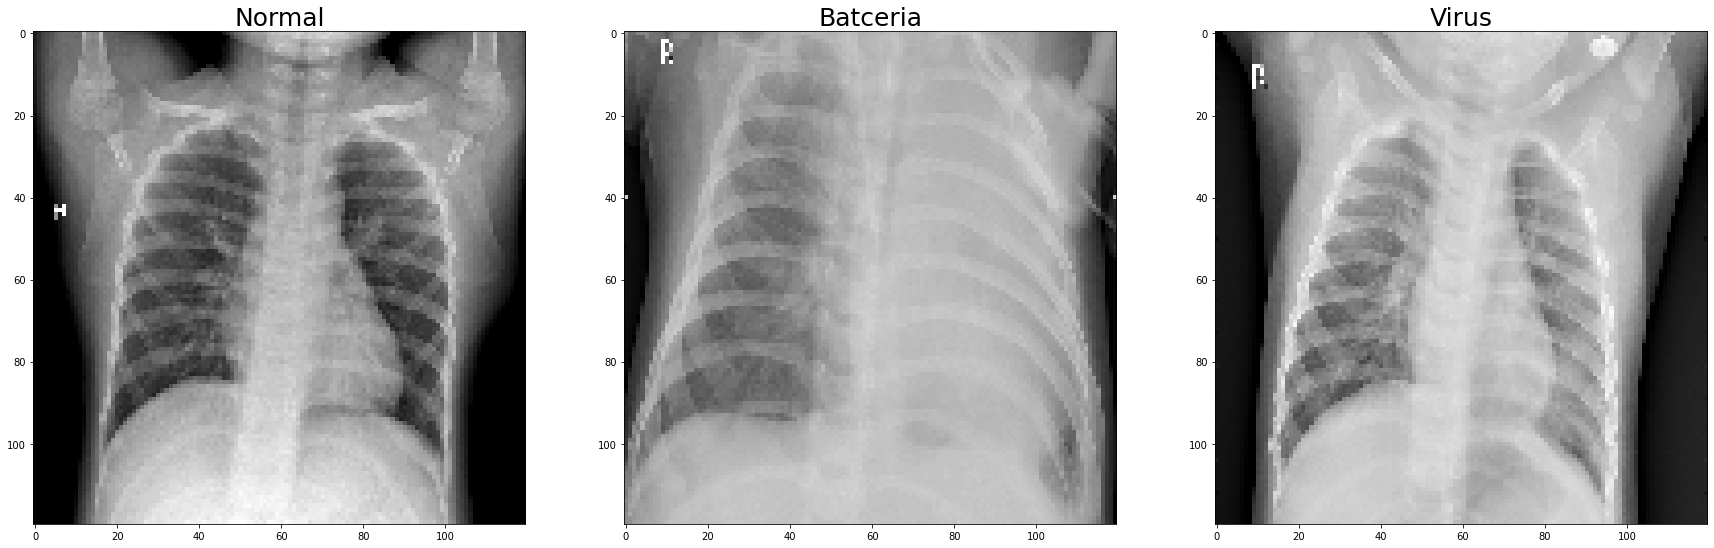

In [22]:
IMG_SIZE= 120
new_array_N = cv2.resize(img_array_N, (IMG_SIZE , IMG_SIZE))
new_array_B = cv2.resize(img_array_B, (IMG_SIZE , IMG_SIZE))
new_array_V = cv2.resize(img_array_V, (IMG_SIZE , IMG_SIZE))

f,(ax0 , ax1, ax2) = plt.subplots(1, 3, figsize=(30, 30))

ax0.imshow(new_array_N , cmap='gray')
ax0.set_title('Normal', fontsize=25)

ax1.imshow(new_array_B , cmap='gray')
ax1.set_title('Batceria', fontsize=25)

ax2.imshow(new_array_V , cmap='gray')
ax2.set_title('Virus', fontsize=25)


We've chosen a size of a 120x120 pixels, wich is enough to distinguish the details without having massive images to deal with, this will be helpfull to reduce the computational charge needed to train the algorithm.

Now, in a variable called new_array we save the images that will be kept in a new dataset called trainig_data in grascale and resized, I'm not sure if it's completely necessary to turn the into grayscale as they are already, at least visually, maybe they have some RGB components we may not notice, or maybe not, gray-scaling is always a good practice so I'll keep it.

In [23]:
training_data = []

def create_trainign_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE , IMG_SIZE))
                training_data.append([new_array , class_num])
            except Exception as e: #In case of any broken images, maybe none of them are, but I'm not checking either
                pass
            
create_trainign_data()    

In [24]:
print(len(training_data))

5232


Now we shuffle the training_data.

In [25]:
import random

random.shuffle(training_data)

Here I demonstrate the rearranged data classes

In [26]:
for sample in training_data[:10]:
    print(sample[1])

1
0
0
2
0
1
2
2
1
2


Let's now divide and save (pickle) the shuffled dataset.

In [27]:
train_x = []
test_y = []

In [28]:
for features, label in training_data:
    train_x.append(features)
    test_y.append(label)

train_x = np.array(train_x).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [29]:
import pickle

pickle_out = open("train_x.pickle","wb")
pickle.dump(train_x, pickle_out)
pickle_out.close()

pickle_out = open("test_y.pickle","wb")
pickle.dump(test_y, pickle_out)
pickle_out.close()

Note: I've pickled my shuffled compressed dataset so I won't need to rerun all the compression and grayscaling when I come back to work on this after reestarting the kernel, because it takes an eternity to do so.

In [30]:
pickle_in = open("train_x.pickle","rb")
train_x = pickle.load(pickle_in)

pickle_in = open("test_y.pickle","rb")
test_y = pickle.load(pickle_in)

I've divided manually the dataset for pneumonia cases as in the same folder there are the Bacteria and Virus infections, by doing so, I've noticed the proportion is unbalanced, so is important to give weight to each class.
First I will use class_weight tool from sklearn to determine each weight.

In [36]:
from sklearn.utils import class_weight
class_w=class_weight.compute_class_weight('balanced', np.unique(test_y), test_y[:])
class_weights={0: class_w[0], 1: class_w[1], 2: class_w[2]}

Alright, let's get this convolution!

In [32]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [37]:
#Here I opened the pickle files again so I can just run this cell to check my CNN
pickle_in = open("train_x.pickle","rb")
train_x = pickle.load(pickle_in)

pickle_in = open("test_y.pickle","rb")
test_y = pickle.load(pickle_in)

#Turning the imgs into a 0 to 1 scale
train_x = train_x/255.0

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = train_x.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

test_y=np.array(test_y)
model.fit(train_x, test_y, batch_size=32, class_weight=class_weights, epochs=3, validation_split=0.3)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/3
115/115 [==============================] - 123s 1s/step - loss: -378.3563 - accuracy: 0.4863 - val_loss: -1731.8510 - val_accuracy: 0.5255
Epoch 2/3
115/115 [==============================] - 120s 1s/step - loss: -40591.1680 - accuracy: 0.4965 - val_loss: -84853.3594 - val_accuracy: 0.5363
Epoch 3/3
115/115 [==============================] - 120s 1s/step - loss: -403906.9688 - accuracy: 0.4984 - val_loss: -557611.0000 - val_accuracy: 0.5382
